In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
yield_df = pd.read_csv('./Data/Processed/yield_data.csv', header = [0])
date_col = pd.to_datetime(yield_df.pop('Date'))
yield_df.index = date_col

In [3]:
FFR_df = pd.read_csv('./Data/Raw Data/US FFR.csv', header = [0])
FFR_date_col = pd.to_datetime(FFR_df.pop('Date'))
FFR_df.index = FFR_date_col
FFR_df = FFR_df.sort_index()

In [4]:
start_date = yield_df.index[0]
FFR_df = FFR_df[start_date - pd.Timedelta(days = 90):]

In [5]:
pca = PCA(n_components=3)
pca.fit(yield_df)

PCA(n_components=3)

In [6]:
print(pca.explained_variance_ratio_)

[0.93721211 0.05858652 0.00363928]


In [7]:
date_range = []
for i in range(len(FFR_df) - 1):
    date_range.append((FFR_df.index[i], FFR_df.index[i + 1]))

In [8]:
PCA_results = []
PCA_explained_ratio = []
PCA_results_reconstructed = []

for i in date_range:
    yield_candidate = yield_df[i[0]: i[1] - pd.Timedelta(days = 1)]
    pca = PCA(n_components=3)
    pca.fit(yield_candidate)
    yield_transformed = pca.transform(yield_candidate)
    PCA_results.append(yield_transformed)
    PCA_explained_ratio.append(PCA_explained_ratio)
    # print(type(pca.inverse_transform(yield_transformed)))
    PCA_results_reconstructed.append(pca.inverse_transform(yield_transformed))

## Example

In [9]:
def PCA_dataframe_getter(idx):
    example = pd.DataFrame(PCA_results[0])
    example.columns = ['Level', 'Slope', 'Curvature']
    example.index = yield_df[date_range[idx][0]: (date_range[idx][1] - pd.Timedelta(days = 1))].index

    plt.figure(figsize = (10, 8))
    for i in range(0, 3):
        col_i = example.iloc[:, i]
        name = ['Level', 'Slope', 'Curvature'][i]
        plt.plot(col_i, label = name, alpha = 0.8)
    
    plt.legend()
    plt.grid()
    plt.xlabel('Date')
    plt.ylabel('Principle Factor Value')
    plt.show()

    return example

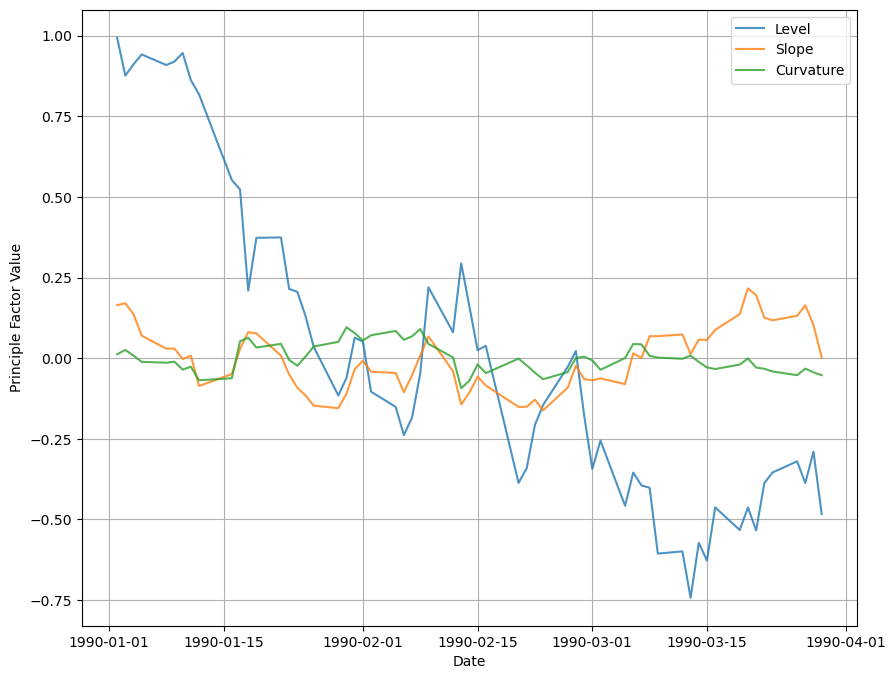

In [10]:
df_0 = PCA_dataframe_getter(0)

In [42]:
def yield_reconstruction(idx, col_name = 'USGG6M'):
    data_1 = PCA_results_reconstructed[idx]
    data_2 = yield_df[date_range[idx][0]: date_range[idx][1] - pd.Timedelta(days = 1)]
    data_1 = pd.DataFrame(data_1, index = data_2.index)
    data_1.columns = ['USGG3M', 'USGG6M', 'USGG2YR', 'USGG5YR', 'USGG10YR', 'USGG30YR']

    data_1 = data_1[[col_name]]
    data_2 = data_2[[col_name]]

    plt.figure(figsize = (12, 8))
    plt.plot(data_2, label = 'Original Yield Curve', alpha = 0.8)
    plt.plot(data_1, label = 'Reconstructed Yield Curve (3 components)', alpha = 0.8)

    plt.ylabel('Yield Value')
    plt.legend()
    plt.grid()
    plt.show()


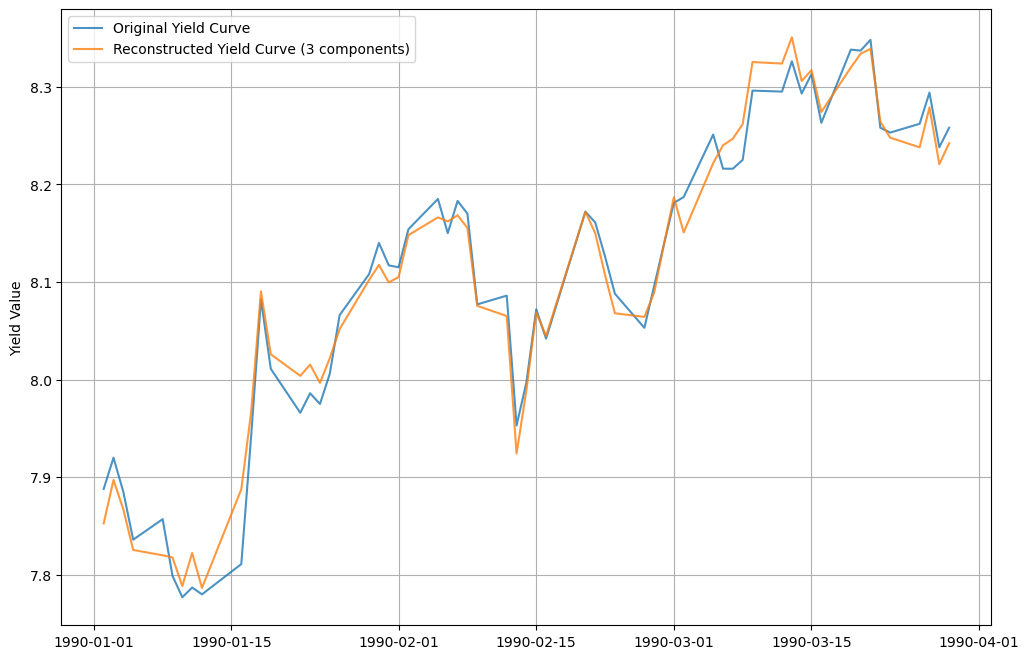

In [43]:
yield_reconstruction(0)